# Movie Lens Dataset: Cleaning and Defining the Hypothesis
## Milestone 1
---

## 1. Problem Statement and Hypothesis

## Problem Statement

In the movie industry, understanding audience preferences can be crucial for targeted marketing and content creation. With the rise of data-driven decision-making, leveraging user demographics, like occupation, can provide a deeper understanding of movie preferences. 

**Question**: Does the occupation of movie raters correlate with their preferences for certain movie genres?

---

## Hypothesis

### Null Hypothesis (H_0):
The occupation of movie raters does not have any correlation with the ratings they give to different movie genres. In other words, the distribution of ratings across genres is the same for all occupations.

### Alternative Hypothesis (H_a):
The occupation of movie raters correlates with the ratings they give to different movie genres. This would imply that certain occupations tend to rate some genres higher or lower than others.

---

## Intuition & Explanation

Occupation can be seen as a reflection of an individual's interests, educational background, and daily activities. For instance, someone in a creative field might have a preference for dramas or art films, while someone in a technical field might lean towards sci-fi or action movies. If our data shows significant differences in genre ratings across occupations, businesses could target their advertising campaigns more effectively, and filmmakers could understand their audience better.

However, it's also possible that movie preferences are more universal and less influenced by one's job. This is the essence of our null hypothesis: that movie genre preferences are independent of occupation.

By testing this hypothesis, we aim to provide insights that could be valuable for movie producers, streaming platforms, and marketing teams.

# 2. Studying the Dataset

In [23]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## 2.1. Initial Exploration



Using the README file, we can assign the columns names to the appropriate files. We are then inspecting each dataframe to begin our analysis.

In [24]:
movies = pd.read_csv('movies.dat', sep='::', names=['MovieID', 'Title', 'Genres'], engine='python', encoding='latin-1')

# Break up each genre (separator is '|') into its own row
movies = movies.set_index(['MovieID', 'Title']).Genres.str.split('|', expand=True).stack().reset_index(['MovieID', 'Title'])

movie_cols = ['MovieID', 'Title', 'Genre']
movies.columns = movie_cols

# Create new column for release year (extract from title)
movies['Year'] = movies['Title'].str.extract('.*\((.*)\).*', expand=True)
movies['Title'] = movies['Title'].str.replace(r"\(.*\)","", regex=True)

movies.head()

,MovieID,Title,Genre,Year
0,1,Toy Story,Animation,1995
1,1,Toy Story,Children's,1995
2,1,Toy Story,Comedy,1995
0,2,Jumanji,Adventure,1995
1,2,Jumanji,Children's,1995


In [25]:
ratings = pd.read_csv('ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python', encoding='latin-1')

# Convert 'Timestamp' from Unix timestamp to datetime
ratings['Rating Date'] = pd.to_datetime(ratings['Timestamp'], unit='s')

# Convert datetime to date in 'YYYY-MM-DD' format
ratings['Rating Date'] = ratings['Rating Date'].dt.date

ratings

,UserID,MovieID,Rating,Timestamp,Rating Date
0,1,1193,5,978300760,2000-12-31
1,1,661,3,978302109,2000-12-31
2,1,914,3,978301968,2000-12-31
3,1,3408,4,978300275,2000-12-31
4,1,2355,5,978824291,2001-01-06
...,...,...,...,...,...
1000204,6040,1091,1,956716541,2000-04-26
1000205,6040,1094,5,956704887,2000-04-25
1000206,6040,562,5,956704746,2000-04-25
1000207,6040,1096,4,956715648,2000-04-26


In [26]:
users = pd.read_csv('users.dat', sep='::', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python', encoding='latin-1')

# Map Occupation to Occupation Name in 'occupations.csv'
occupations = pd.read_csv('occupations.csv', sep=',', names=['Occupation', 'Occupation Name'], engine='python', encoding='latin-1')

# Merge users on occupations
users = users.merge(occupations, on='Occupation', how='left')

# Drop Occupation column
users = users.drop('Occupation', axis=1)

# Rename Occupation Name to Occupation
users = users.rename(columns={'Occupation Name': 'Occupation'})

# Function to categorize age
def categorize_age(age):
    if age < 18:
        return "Under 18"
    elif age < 25:
        return "18-24"
    elif age < 35:
        return "25-34"
    elif age < 45:
        return "35-44"
    elif age < 50:
        return "45-49"
    elif age < 56:
        return "50-55"
    else:
        return "56+"

# Applying the function to create a new column
users['Age_Categories'] = users['Age'].apply(categorize_age)

users

,UserID,Gender,Age,Zip-code,Occupation,Age_Categories
0,1,F,1,48067,K-12 student,Under 18
1,2,M,56,70072,self-employed,56+
2,3,M,25,55117,scientist,25-34
3,4,M,45,02460,executive,45-49
4,5,M,25,55455,writer,25-34
...,...,...,...,...,...,...
6035,6036,F,25,32603,scientist,25-34
6036,6037,F,45,76006,educator,45-49
6037,6038,F,56,14706,educator,56+
6038,6039,F,45,01060,other,45-49


In [27]:
# Make all column names lowercase in ratings, users, and movies
ratings.columns = ratings.columns.str.lower()
users.columns = users.columns.str.lower()
movies.columns = movies.columns.str.lower()

## 2.2. Identifying Relevant Variables

### Movies Dataset
The `movies_df` contains information about movies, such as the title, release date, and various genre flags (indicating the genres a movie belongs to). The genres are particularly relevant because they represent the categories for which we want to analyze ratings. We'll also use the `movie id` for merging datasets later.

**Key Variables**:
- `movie id`: Will be used to match ratings with movies.
- Genre Flags (e.g., `Action`, `Adventure`, `Animation`, etc.): To categorize movies and analyze ratings based on genre.

### Ratings Dataset
The `ratings_df` provides ratings given by users to movies. The rating and the association between user and movie are crucial.

**Key Variables**:
- `user id`: To identify which user gave a particular rating.
- `movie id`: To match the rating with a specific movie.
- `rating`: The actual rating value, which is central to our analysis.

### Users Dataset
The `users_df` contains demographic information about users. Since our hypothesis revolves around the occupation of users and their ratings, occupation is of paramount importance. Additionally, other demographics might provide supplemental insights.

**Key Variables**:
- `user id`: To match the user's demographic information with their ratings.
- `occupation`: Central to our hypothesis. We'll analyze ratings based on this.
- `age`, `gender`: Additional demographics that might be used for supplemental analysis.

_Given our hypothesis, the occupation of users and the genres of movies are the two most significant variables. We believe that occupation, a reflection of a person's interests and daily activities, might influence their movie preferences. For instance, someone in a technical field might be inclined towards sci-fi movies, while a healthcare worker might prefer dramas. By correlating occupation with genre-based ratings, we can test this belief._

_However, it's essential to understand that correlation does not imply causation. Even if we find a significant correlation between occupation and genre preference, other lurking variables (like age or gender) might also play a role._

## 3. Data Cleaning


### 3.1. Identifying Outliers


For our current datasets, the rating and age columns are the primary numerical features. However, since rating is categorical in nature (with values ranging from 1 to 5), it doesn't typically have "outliers". The age column, on the other hand, can be inspected for any unusual values that fall outside the expected range for human ages.

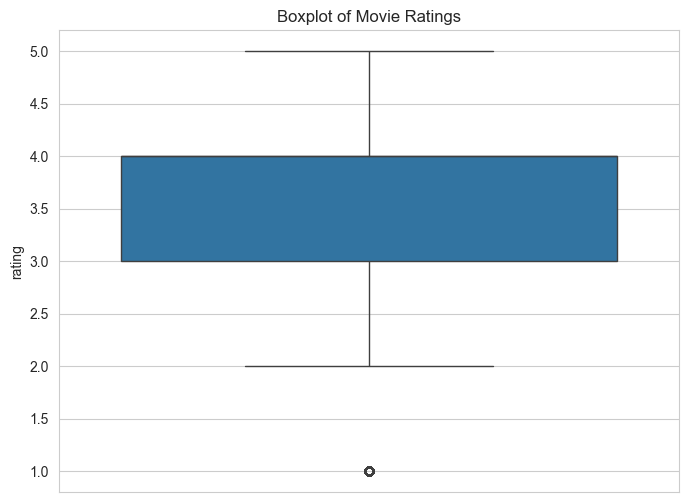

In [28]:
# Boxplot for ratings to identify outliers
plt.figure(figsize=(8, 6))
sns.boxplot(ratings['rating'])
plt.title('Boxplot of Movie Ratings')
plt.show()


The boxplot shows us that ratings dataframe does not contain any outliers, as there are no values outside the 1-5 range. The ratings are all between 1 and 5, as expected. Yet, we can make an observation that not many users have rated movies below 2. 

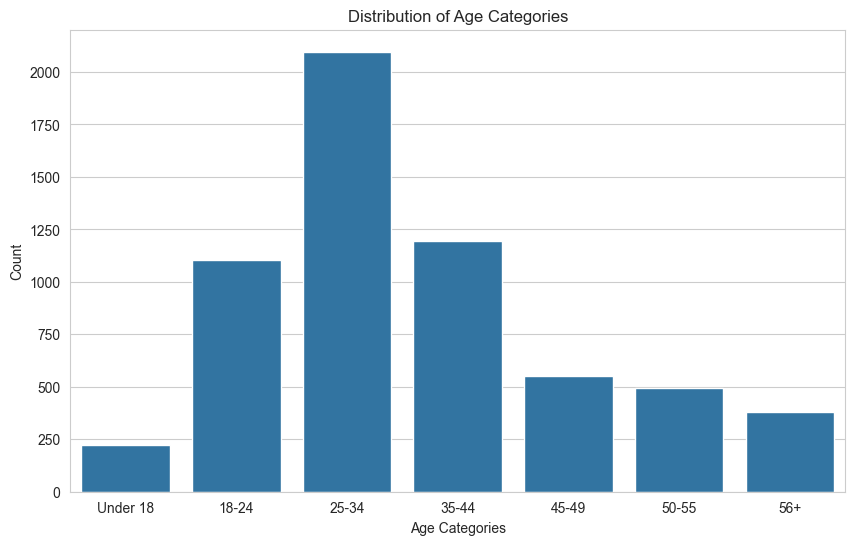

In [29]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting the distribution of age categories
plt.figure(figsize=(10, 6))
sns.countplot(x='age_categories', data=users, order=['Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+'])
plt.title('Distribution of Age Categories')
plt.xlabel('Age Categories')
plt.ylabel('Count')
plt.show()

We don't see any outliers in the age column either. All the ages are within the expected human ages. However, we can see that the majority of users are between 20 and 40 years old. This is an important observation because it might skew our analysis towards the preferences of younger users.

### 3.2 Removing Unnecessary Columns

From our movies dataframe, some columns like IMDb URLs, release date and video release date might not be relevant for our analysis.

In [30]:
# # Dropping unnecessary columns from the movie dataset
# movies.drop(columns=['IMDb URL', 'release date', 'video release date'], inplace=True)

# # Confirming the drop
# movies.head()

Dropping timestamp column from ratings dataframe. 

In [31]:
# Dropping 'timestamp' from the ratings dataset
# ratings_df.drop(columns=['timestamp'], inplace=True)

Dropping zip code column from users dataframe.

In [32]:
# Dropping 'zip code' from the users dataset
# users_df.drop(columns=['zip code'], inplace=True)

### 3.3. Handling Missing Values


Different ways to handle missing values:
- Deletion: If the number of missing values in a row or column is substantial, sometimes it's easier to remove that row or column.
- Imputation: For columns with a few missing values, we can replace missing values with the median, mean, or mode of that column. The method of imputation would depend on the nature of the data.

In [33]:
# Check for missing data
missing_data = {
    "Users": users.isnull().sum(),
    "Ratings": ratings.isnull().sum(),
    "Movies": movies.isnull().sum()
}

print(missing_data)

{'Users': userid            0
gender            0
age               0
zip-code          0
occupation        0
age_categories    0
dtype: int64, 'Ratings': userid         0
movieid        0
rating         0
timestamp      0
rating date    0
dtype: int64, 'Movies': movieid    0
title      0
genre      0
year       0
dtype: int64}


Here, we can see that none of the colums have any missing values. We can proceed without dropping any rows or columns or imputing any values.

### 3.4. Checking for Duplicates

Duplicate rows can skew the analysis, leading to incorrect conclusions. Thus, identifying and removing them is essential.

In [34]:
# Check for duplicates in each dataset
duplicates_data = {
    "Users": users.duplicated().sum(),
    "Ratings": ratings.duplicated().sum(),
    "Movies": movies.duplicated().sum()
}

duplicates_data

{'Users': 0, 'Ratings': 0, 'Movies': 0}

### 3.5 Feature Transformation

Our aim is to simplify the structure of our movie dataset, specifically the representation of movie genres. In its current form, each genre is represented as a separate column with binary values indicating whether a movie belongs to that genre. This wide-format structure, while informative, can be cumbersome for analysis, especially when we want to correlate ratings with genres and occupations.

The melt() Function
To achieve our objective, we'll use the melt() function from pandas. This function is designed to transform or reshape data from a wide format to a long format.

In a wide format, data is spread across multiple columns, and in a long format, data is stacked into fewer columns, making the dataset longer.

In [35]:
# # Melt the dataframe to long format with movie id, movie title, and genre
# movies_long = movies_df.melt(id_vars=['movie id', 'movie title'],
#                              value_vars=['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 
#                                          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
#                                          'Thriller', 'War', 'Western'],
#                              var_name='genre',
#                              value_name='value')

# # Filtering out rows where the genre value is 1 (i.e., the movie belongs to that genre)
# movies_long_filtered = movies_long[movies_long['value'] == 1].copy()

# # Drop the 'value' column as we don't need it anymore
# movies_long_filtered.drop(columns=['value'], inplace=True)

# movies_long_filtered.head()


After our transformation, it's essential to note that the dataset now contains duplicate movie entries. This is because movies that belong to multiple genres will have a separate row for each genre they are associated with. For example, a movie that belongs to both "Action" and "Adventure" genres will have two rows in the dataset - one for each genre.

While in many scenarios, duplicates are seen as data inconsistencies, in our case, they are intentional and beneficial. These duplicates are vital for our analysis since they allow us to investigate the relationship between occupations and individual movie genres more effectively. Without this structure, our analysis would be limited, and we wouldn't be able to derive meaningful insights about genre preferences across different occupations.

Thus, as we progress, it's crucial to remember that while the movie titles might repeat, each row represents a unique combination of a movie and its genre, which is essential for our hypothesis testing.

### 3.7. Data Type Conversion

Ensuring that all relevant variables are of the correct data type is crucial for our analysis. Incorrect data types can lead to errors during computations or give misleading results.

First, let's examine the data types of the columns in our datasets.

In [36]:
# Check data types for each dataset
data_types_movies = movies.dtypes
data_types_ratings = ratings.dtypes
data_types_users = users.dtypes

data_types_movies, data_types_ratings, data_types_users

(movieid     int64
 title      object
 genre      object
 year       object
 dtype: object,
 userid          int64
 movieid         int64
 rating          int64
 timestamp       int64
 rating date    object
 dtype: object,
 userid             int64
 gender            object
 age                int64
 zip-code          object
 occupation        object
 age_categories    object
 dtype: object)

1. **`movie title`** and **`genre`** in the `movies_long_filtered` dataset are of type `object`. Given that these are textual or categorical variables, it's a good idea to convert them to `category` type to reduce memory usage and speed up operations.
  
2. **`gender`** and **`occupation`** in the `users_df` dataset are also of type `object`. They should be converted to `category` type for the same reasons mentioned above.

3. The `ratings_df` dataset seems fine with `int64` type for its columns.


In [37]:
# Convert 'movie title' and 'genre' in movies_long_filtered dataset to categorical type
movies['title'] = movies['title'].astype('category')
movies['genre'] = movies['genre'].astype('category')

# Convert 'gender' and 'occupation' in users_df dataset to categorical type
users['gender'] = users['gender'].astype('category')
users['occupation'] = users['occupation'].astype('category')


After these conversions, our datasets' columns should now have the optimal data types for our analysis. These conversions help in reducing memory usage and provide faster operations, especially for operations involving categorical variables.

### 3.8 Merging Datasets

Given our hypothesis, we are interested in studying the relationship between `occupation`, `genre`, and `rating`. The data related to these variables is spread across our three datasets:

- `users_df` contains the `occupation` of each user.
- `ratings_df` contains the `rating` given by a user to a movie.
- `movies_long_filtered` contains the `genre` of each movie.

To effectively analyze the relationship between these variables, it's essential to have them in a single dataframe. Merging the dataframes achieves this and facilitates easier and more efficient analyses.

In [38]:
# Merge ratings and users on UserID
merged_df = pd.merge(ratings, users, on='userid')

# Merging the above result with movies_long_filtered on 'movie id'
merged_df = pd.merge(merged_df, movies, on='movieid')

merged_df.drop(columns=['timestamp'], inplace=True)

# merged_df.sort_values(by='year', inplace=True)

merged_df

,userid,movieid,rating,rating date,gender,age,zip-code,occupation,age_categories,title,genre,year
0,1,1193,5,2000-12-31,F,1,48067,K-12 student,Under 18,One Flew Over the Cuckoo's Nest,Drama,1975
1,2,1193,5,2000-12-31,M,56,70072,self-employed,56+,One Flew Over the Cuckoo's Nest,Drama,1975
2,12,1193,4,2000-12-30,M,25,32793,programmer,25-34,One Flew Over the Cuckoo's Nest,Drama,1975
3,15,1193,4,2000-12-30,M,25,22903,executive,25-34,One Flew Over the Cuckoo's Nest,Drama,1975
4,17,1193,5,2000-12-30,M,50,95350,educator,50-55,One Flew Over the Cuckoo's Nest,Drama,1975
...,...,...,...,...,...,...,...,...,...,...,...,...
2101810,5780,2845,1,2000-05-12,M,18,92886,technician,18-24,White Boys,Drama,1999
2101811,5851,3607,5,2000-05-08,F,18,55410,writer,18-24,One Little Indian,Comedy,1973
2101812,5851,3607,5,2000-05-08,F,18,55410,writer,18-24,One Little Indian,Drama,1973
2101813,5851,3607,5,2000-05-08,F,18,55410,writer,18-24,One Little Indian,Western,1973


While the comprehensive merged dataframe is valuable, for our specific hypothesis, we only need the occupation, genre, and rating columns. Filtering out unnecessary columns will make our analyses more efficient and focused.

### TODO: EXPLICITLY STATE THE AGE AS CATEGORIES

In [39]:
# Selecting only 'occupation', 'genre', and 'rating' columns
filtered_df = merged_df[['occupation', 'genre', 'rating']]

filtered_df.head()

,occupation,genre,rating
0,K-12 student,Drama,5
1,self-employed,Drama,5
2,programmer,Drama,4
3,executive,Drama,4
4,educator,Drama,5


## 4. Basic Data Exploration
### 4.1. Distribution of Ratings
Understanding the overall distribution of ratings can give us an idea of how users generally perceive movies.

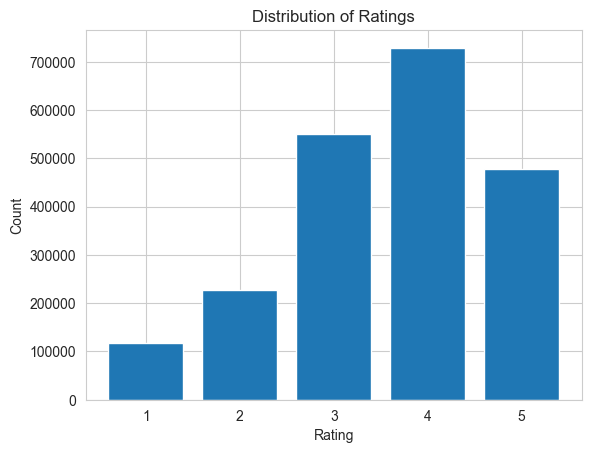

In [40]:
import matplotlib.pyplot as plt

plt.bar(filtered_df['rating'].value_counts().index, filtered_df['rating'].value_counts().values)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


### 4.2. Top Rated Genres
Which genres have the highest average ratings? This can give insights into the most liked genres overall.

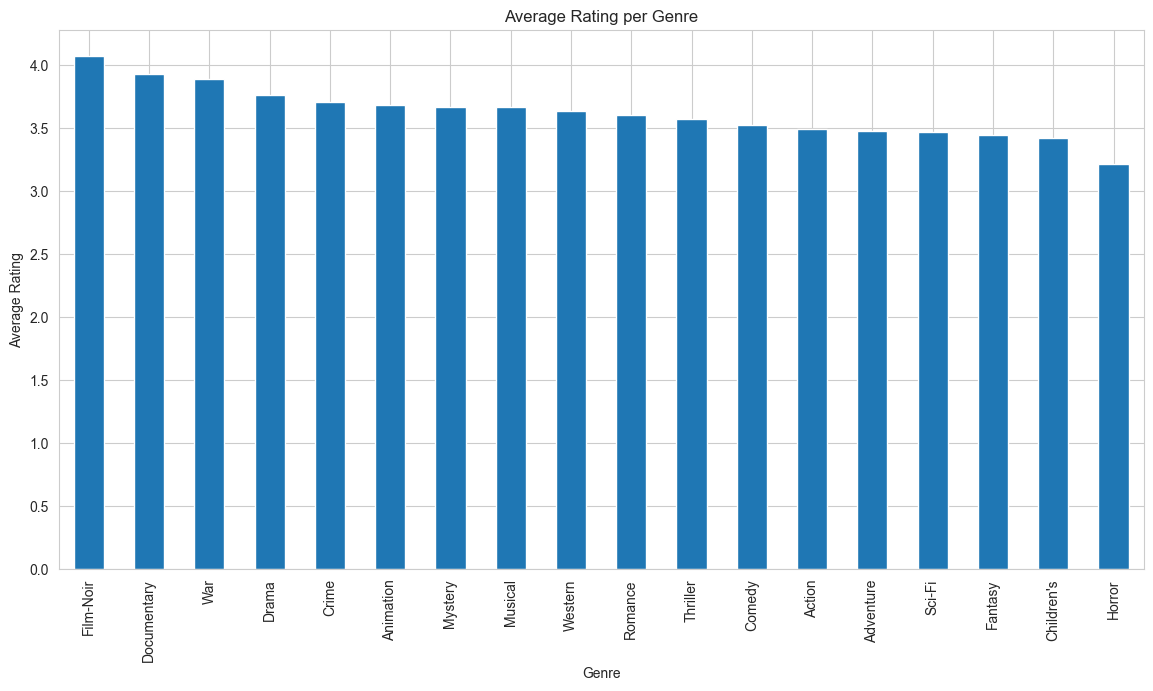

In [41]:
genre_rating = filtered_df.groupby('genre')['rating'].mean().sort_values(ascending=False)
genre_rating.plot(kind='bar', figsize=(14,7))
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.show()


### 4.3. Number of Ratings by Occupation
Understanding the number of ratings by occupation can give us insights into which occupations are most active in rating movies.

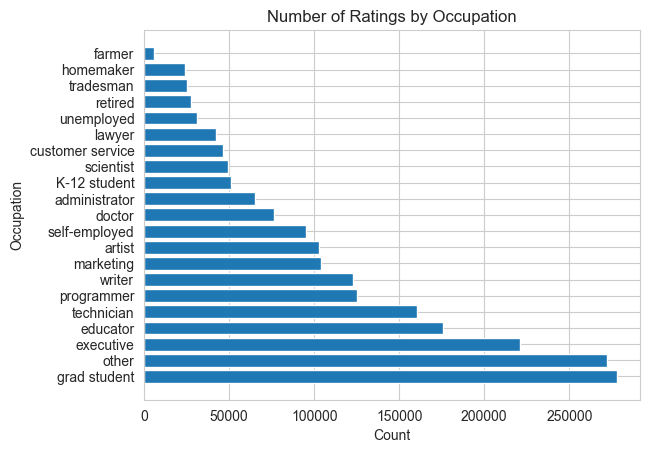

In [42]:
plt.barh(filtered_df['occupation'].value_counts().index, filtered_df['occupation'].value_counts().values)
plt.title('Number of Ratings by Occupation')
plt.xlabel('Count')
plt.ylabel('Occupation')
plt.show()

### 4.4. Average Rating by Occupation
Which occupations give the highest and lowest average ratings?

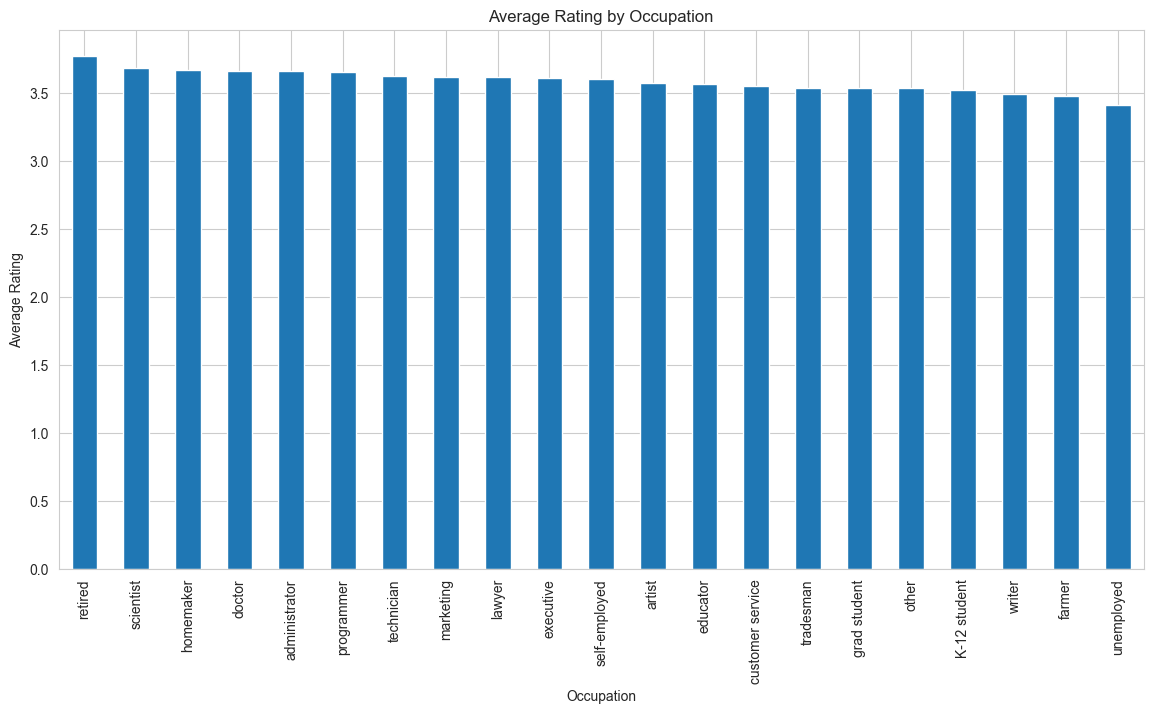

In [43]:
occupation_rating = filtered_df.groupby('occupation')['rating'].mean().sort_values(ascending=False)
occupation_rating.plot(kind='bar', figsize=(14,7))
plt.title('Average Rating by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Rating')
plt.show()


### 4.5. Most Popular Genres by Occupation
For each occupation, which genre has the highest average rating?

In [44]:
occupation_genre_rating = filtered_df.groupby(['occupation', 'genre'])['rating'].mean().unstack()
most_popular_genres = occupation_genre_rating.idxmax(axis=1)
print(most_popular_genres)

occupation
K-12 student          Film-Noir
administrator         Film-Noir
artist                Film-Noir
customer service      Film-Noir
doctor              Documentary
educator              Film-Noir
executive             Film-Noir
farmer              Documentary
grad student          Film-Noir
homemaker                   War
lawyer                Film-Noir
marketing             Film-Noir
other                 Film-Noir
programmer            Film-Noir
retired               Film-Noir
scientist             Film-Noir
self-employed         Film-Noir
technician            Film-Noir
tradesman             Film-Noir
unemployed            Film-Noir
writer                Film-Noir
dtype: object
